 # Learning about network behavior with Mahi-Mahi
 
 ## Summary
 
[mahimahi](http://mahimahi.mit.edu/) is a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.
 
This jupyter notebook uses mahimahi to demonstrate how network traffic operates under different conditions.
 
The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
 ## Installation
 
 I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install jupyter

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10)
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```
 
 ## TODO

I will be adding implementations of different congestion control algorithms here and comparing how each of them
does under different networking conditions.


In [1]:
import mpld3
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy

mpld3.enable_notebook()

In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

In [3]:
# class RenoSender(Sender):
#     def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
#         self.initial_cwnd = initial_cwnd
#         self.cwnd = initial_cwnd
#         self.slow_start_thresh = slow_start_thresh

#         super().__init__(port)
        
#     def window_is_open(self):
#         # Returns true if the congestion window is not full
#         return self.seq_num - self.next_ack < self.cwnd

#     def send(self):
#         serialized_data = json.dumps({
#             'seq_num': self.seq_num,
#             'send_ts': time.time(),
#             'sent_bytes': self.sent_bytes
#         })
#         self.unacknowledged_packets[self.seq_num] = True
#         self.seq_num += 1
#         self.sock.sendto(serialized_data.encode(), self.peer_addr)
#         time.sleep(0)
    
#     def recv(self):
#         serialized_ack, addr = self.sock.recvfrom(1600)

#         ack = json.loads(serialized_ack.decode())
#         if ack.get('handshake'):
#             return
        
#         self.total_acks += 1
#         self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

#         if self.unacknowledged_packets.get(ack['seq_num']) is None:
#             # Duplicate ack

#             self.num_duplicate_acks += 1
#             self.curr_duplicate_acks += 1
            
#             if self.curr_duplicate_acks == 3:
#                 # Received 3 duplicate acks, retransmit

#                 self.seq_num = ack['seq_num'] + 1
#                 self.slow_start_thresh = self.cwnd/2
#                 self.cwnd = self.slow_start_thresh
#         else:
#             self.curr_duplicate_acks = 0
#             del self.unacknowledged_packets[ack['seq_num']]
#             self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
#             self.sent_bytes += ack['ack_bytes']
#             rtt = float(time.time() - ack['send_ts'])
#             self.rtts.append(rtt)
#             if self.cwnd < self.slow_start_thresh:
#                 # In slow start
#                 self.cwnd += 1 
#             elif ack['seq_num'] % self.cwnd == 0:
#                 # In congestion avoidance
#                 self.cwnd += 1
    
#         self.cwnds.append(self.cwnd) 

In [12]:
DEAULT_TIMEOUT = 2
BETA_CUBIC = 0.7

class CubicStrategy(SenderStrategy):
    def __init__(self, c: int) -> None:

        self.cwnd = 2
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        
        self.c = c
        self.slow_start_threshold = 42
        self.w_max = 42
        
        self.congestion_avoidance_began_at = None
        self.fast_retransmitted_packets_in_flight = []
        
        self.duplicated_ack = None
        self.slow_start_thresholds = []
        self.first_rtt = None
        self.timeout = DEFAULT_TIMEOUT

        super().__init__()

    def compute_w_est(self) -> int:
        average_rtt = sum(self.rtts)/len(self.rtts)
        
        return (
            self.w_max * BETA_CUBIC + (
              ((3*(1 - BETA_CUBIC)) * (
                  (time.time() - self.congestion_avoidance_began_at)/self.first_rtt) ) /(1 + BETA_CUBIC)
            )
        )
    
    def compute_w_cubic(self, t: float) -> int:
        k = (self.w_max * ((1 - BETA_CUBIC)/self.c)) ** (1/3)
        #print("k: %d, t: %f, w_max: %d" % (k, t, self.w_max))
        return self.c * (((t)-k) ** 3) + self.w_max
    
    def average_rtt(self):
        return sum(self.rtts)/len(self.rtts)
    
    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > self.timeout:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
#             if in_greater_than_one_retransmit:
#                 print("Retransmitting > 1 time")
#             print("retransmitting %d" % (self.fast_retransmit_packet['seq_num']))
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > self.timeout:   
                    print("Timedout packet id: %d and current seq_num is %d" % (seq_num, self.seq_num))
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    self.w_max = self.cwnd
                    self.slow_start_threshold = self.cwnd * BETA_CUBIC
                    self.slow_start_threshold = max(self.slow_start_threshold, 2)
                    self.cwnd = 1
                    self.congestion_avoidance_began_at = None
                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
#                 print(self.fast_retransmitted_packets_in_flight)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                print("Lost packet id: %d" % (ack['seq_num'] + 1))
                self.w_max = self.cwnd
                self.slow_start_threshold = self.cwnd * BETA_CUBIC
                self.slow_start_threshold = max(self.slow_start_threshold, 2)
                self.congestion_avoidance_began_at = None
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                
#                 print("Recovering from fast retrasmit w/ seq_num %d, new seq_num is %d" % (ack['seq_num'], self.seq_num))
                self.fast_retransmitted_packets_in_flight = []

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            if self.first_rtt is None:
                self.first_rtt = rtt
            self.rtts.append(rtt)
            self.timeout = rtt * 1.2

            if self.congestion_avoidance_began_at is None and self.cwnd >= self.slow_start_threshold:
                self.congestion_avoidance_began_at = time.time()
            
            if self.cwnd < self.slow_start_threshold:

                # In slow start
                self.cwnd += 1

            else:
                # In congestion avoidance
                w_est = self.compute_w_est()
                t = (time.time() - self.congestion_avoidance_began_at)
                w_cubic = self.compute_w_cubic(t)
                
                if w_cubic > w_est:
                    a = (self.compute_w_cubic(t + self.first_rtt) - self.cwnd)/self.cwnd
                    self.cwnd += a
                else:
                    self.cwnd = w_est
        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.w_max)




In [5]:
class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        self.timeout = DEFAULT_TIMEOUT
        self.fast_retransmitted_packets_in_flight = []
        
        self.duplicated_ack = None
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > self.timeout:
            # The retransmit packet timed out--resend it
#             print("Retransmitting > 1 time")
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
#             if in_greater_than_one_retransmit:
#                 print("Retransmitting > 1 time")
#             print("retransmitting %d" % (self.fast_retransmit_packet['seq_num']))
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > self.timeout:   
                    print("Timedout packet id: %d and current seq_num is %d" % (seq_num, self.seq_num))
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    self.slow_start_thresh = int(max(1, self.cwnd/2))
                    self.cwnd = 1

                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
                print(self.fast_retransmitted_packets_in_flight)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                print("Lost packet id: %d" % (ack['seq_num'] + 1))
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                
               # print("Recovering from fast retrasmit w/ seq_num %d, new seq_num is %d" % (ack['seq_num'], self.seq_num))
                self.fast_retransmitted_packets_in_flight = []

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            self.timeout = rtt * 1.2
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)

In [6]:

mahimahi_settings = {
    'delay': 88,
    'queue_size': 80000,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
strat = TahoeStrategy(10, 1)

run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strat)])

KeyboardInterrupt: 

[sender] Connected to receiver: 100.64.0.2:41328

Results for sender 33148:
Total Acks: 38235
Num Duplicate Acks: 2022
% duplicate acks: 5.288348
Throughput (bytes/s): 48284.000000
Average RTT (ms): 1631.266334


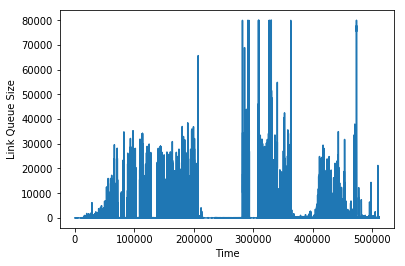

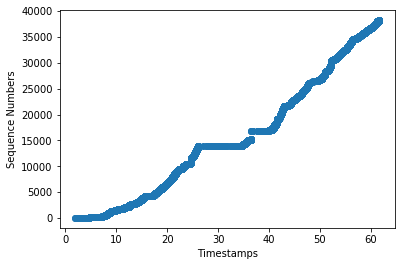

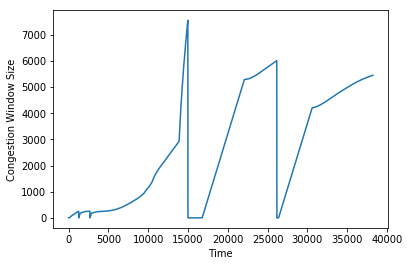

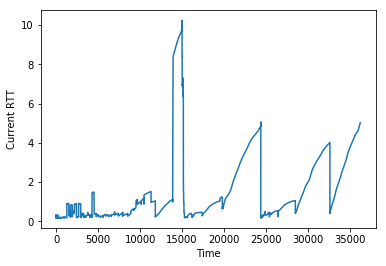

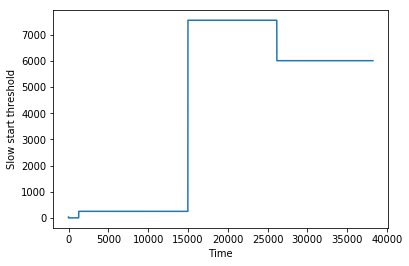

In [12]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 80000,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.4:49062

[281]
Lost packet id: 281
[401]
Lost packet id: 401
[406]
Lost packet id: 406
[1752]
Lost packet id: 1752
[1796]
Lost packet id: 1796
[2355]
Lost packet id: 2355
[3131]
Lost packet id: 3131
[3725]
Lost packet id: 3725
Results for sender 33803:
Total Acks: 4343
Num Duplicate Acks: 271
% duplicate acks: 6.239926
Throughput (bytes/s): 10858.666667
Average RTT (ms): 285.950902


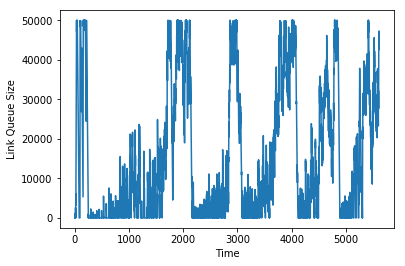

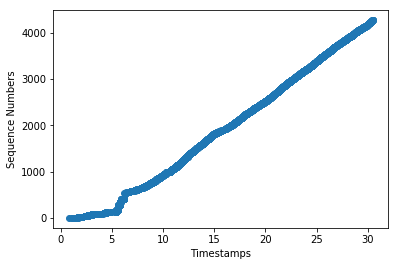

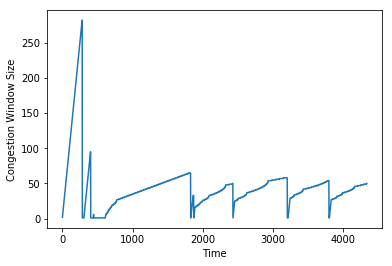

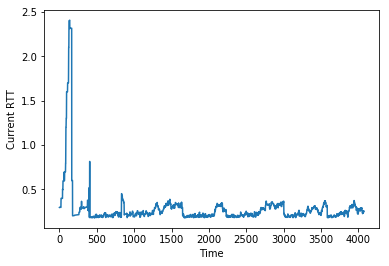

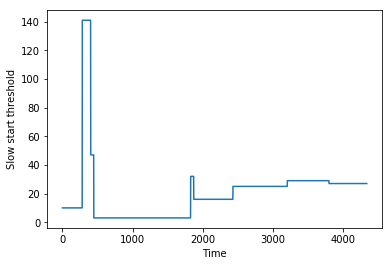

In [6]:
# Droptail
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 30, [Sender(port, strat)])

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS'],
    'queue_type': 'red'
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 30, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.8:33287

[149]
Lost packet id: 149
[551]
Lost packet id: 551
[860]
Lost packet id: 860
[1759]
Lost packet id: 1759
[2723]
Lost packet id: 2723
[2781]
Lost packet id: 2781
[3575]
Lost packet id: 3575
[4014]
Lost packet id: 4014
[4674]
Lost packet id: 4674
Results for sender 57407:
Total Acks: 5049
Num Duplicate Acks: 210
% duplicate acks: 4.159239
Throughput (bytes/s): 12904.000000
Average RTT (ms): 248.400909


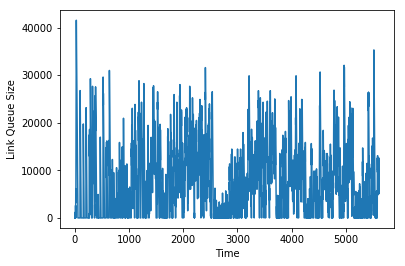

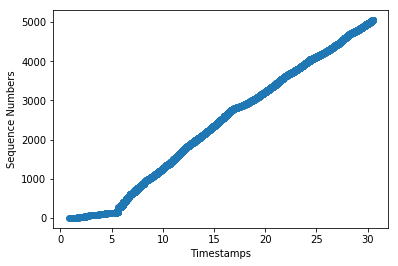

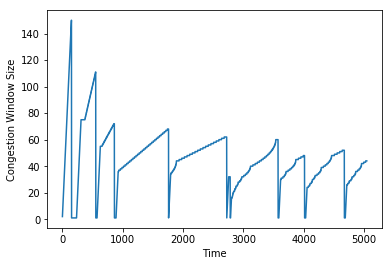

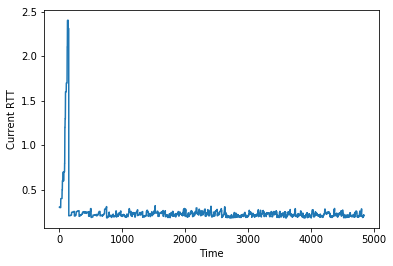

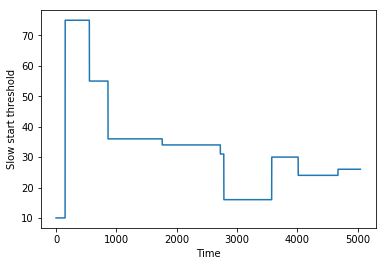

In [6]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': TRACE_FILES['2.64MBPS'],
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.25,
        'maxthresh': 0.75
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 30, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.4:50646

[510]
Lost packet id: 510
[540]
Lost packet id: 540
[627]
Lost packet id: 627
[2052]
Lost packet id: 2052
[3899]
Lost packet id: 3899
[4471]
Lost packet id: 4471
[4868]
Lost packet id: 4868
Results for sender 34211:
Total Acks: 4899
Num Duplicate Acks: 68
% duplicate acks: 1.388038
Throughput (bytes/s): 12882.666667
Average RTT (ms): 308.572733


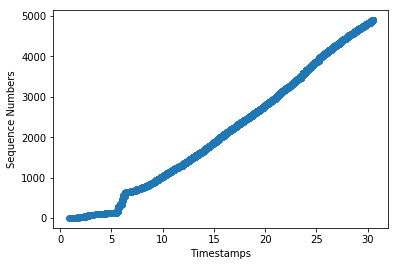

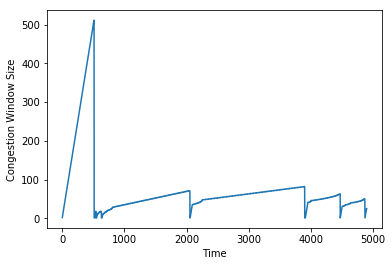

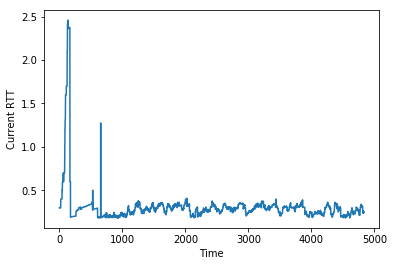

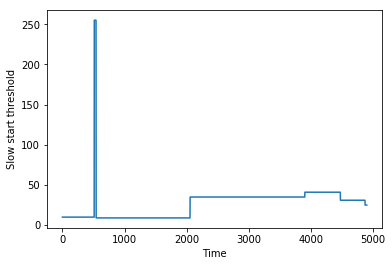

In [8]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': TRACE_FILES['2.64MBPS'],
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000,
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 30, [Sender(port, strat)])

In [47]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS'],
    'queue_type': 'red'
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.26:33368

Timedout packet id: 108 and current seq_num is 151


KeyboardInterrupt: 

[sender] Connected to receiver: 100.64.0.2:47679

Timedout packet id: 108 and current seq_num is 151
Results for sender 59355:
Total Acks: 108
Num Duplicate Acks: 0
% duplicate acks: 0.000000
Throughput (bytes/s): 288.000000
Average RTT (ms): 770.461341


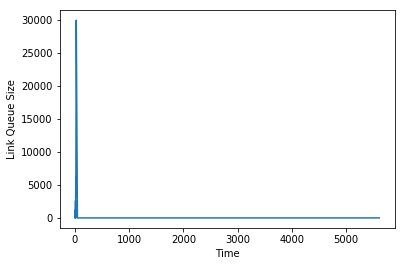

TypeError: Object of type 'ndarray' is not JSON serializable

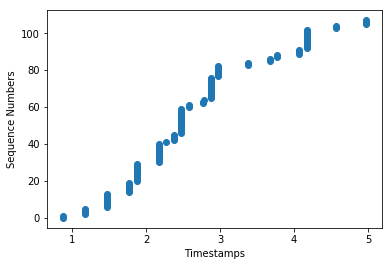

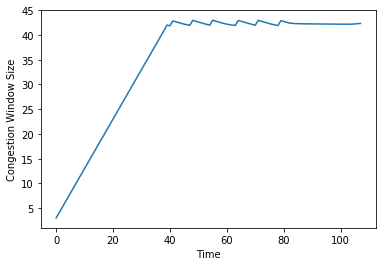

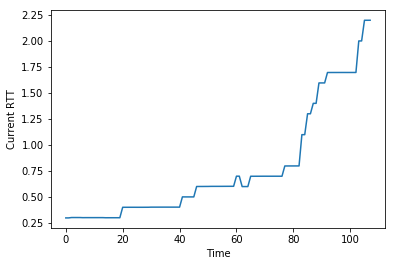

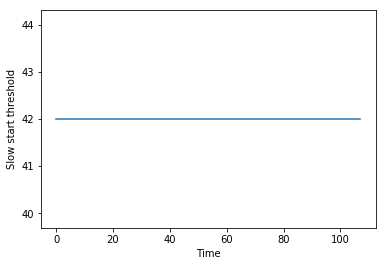

In [48]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS'],
    'queue_type': 'red'
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 30, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.4:57452

Results for sender 43260:
Total Acks: 5024
Num Duplicate Acks: 174
% duplicate acks: 3.463376
Throughput (bytes/s): 19400.000000
Average RTT (ms): 203.422078


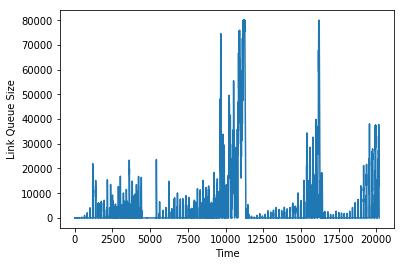

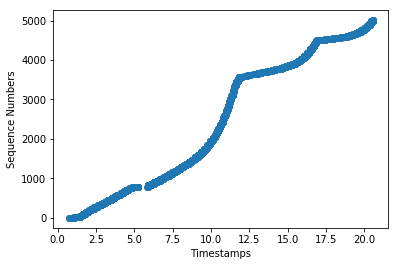

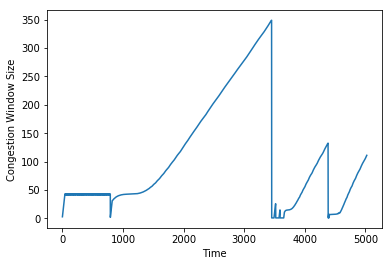

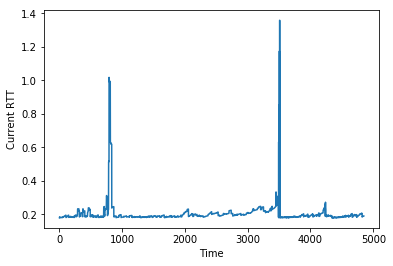

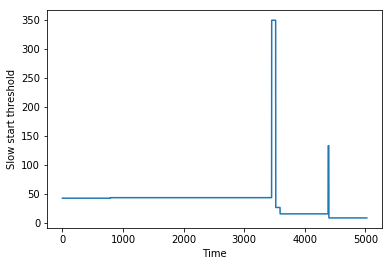

In [20]:
mahimahi_settings = {
    'delay': 88,
    'queue_type': 'droptail',
    
    'trace_file': '12mbps.trace'
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 20, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.26:35903

[929]
Lost packet id: 929
[1300]
Lost packet id: 1300
[1663]
Lost packet id: 1663
[1688]
Lost packet id: 1688
[1724]
Lost packet id: 1724
Timedout packet id: 4403 and current seq_num is 4495
[9839]
Lost packet id: 9839
[9853]
Lost packet id: 9853
[9869]
Lost packet id: 9869
[9901]
Lost packet id: 9901
[9907]
Lost packet id: 9907
[14134]
Lost packet id: 14134
[17654]
Lost packet id: 17654
[17669]
Lost packet id: 17669
[17744]
Lost packet id: 17744
Results for sender 39269:
Total Acks: 19678
Num Duplicate Acks: 428
% duplicate acks: 2.175018
Throughput (bytes/s): 12833.333333
Average RTT (ms): 433.548965


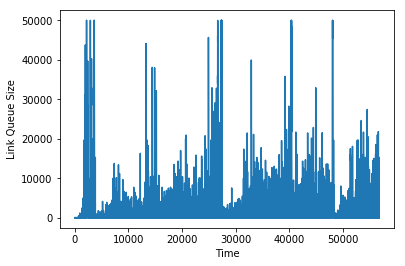

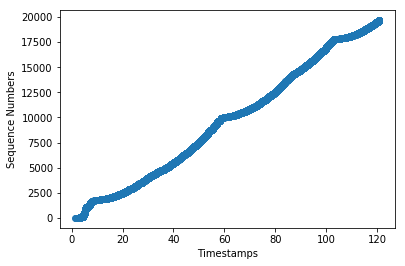

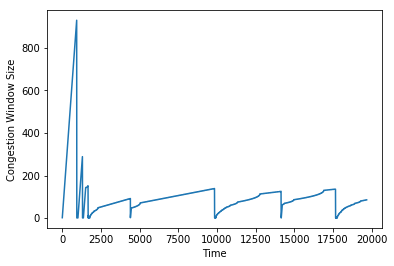

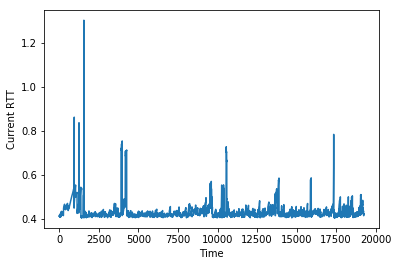

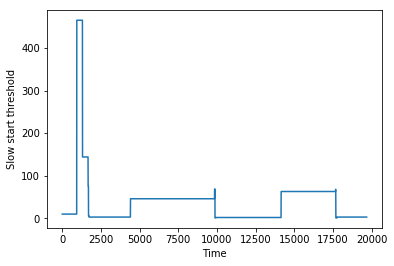

In [20]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.26:51862

Lost packet id: 5170
Lost packet id: 6371
Lost packet id: 6519
Lost packet id: 6969
Lost packet id: 7722
Lost packet id: 7881
Lost packet id: 7920
Lost packet id: 10069
Lost packet id: 13579
Lost packet id: 15747
Lost packet id: 17246
Lost packet id: 23386
Lost packet id: 24117
Lost packet id: 29145
Lost packet id: 30009
Lost packet id: 30011
Lost packet id: 34846
Results for sender 40039:
Total Acks: 36113
Num Duplicate Acks: 3107
% duplicate acks: 8.603550
Throughput (bytes/s): 22004.000000
Average RTT (ms): 761.671611


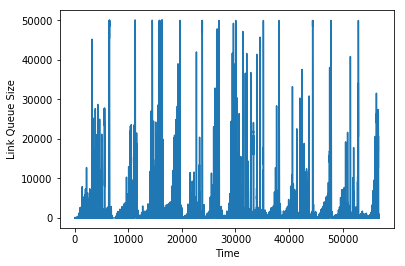

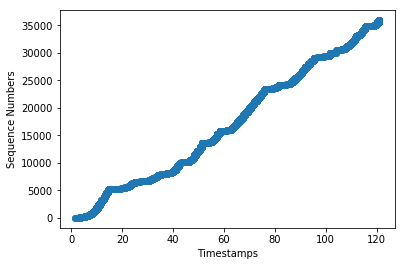

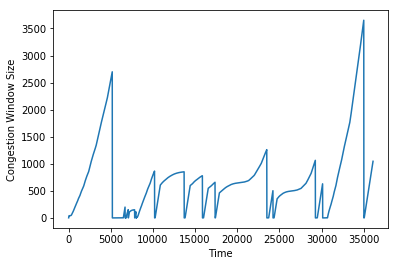

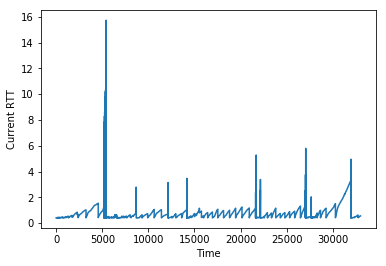

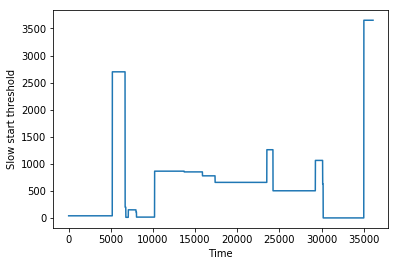

In [21]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.4:41419

[sender] Connected to receiver: 100.64.0.4:41419

[24622]
Lost packet id: 24622
[25288]
Lost packet id: 25288
[25337]
Lost packet id: 25337
[25829]
Lost packet id: 25829
[26964]
Lost packet id: 26964
[27686]
Lost packet id: 27686
[28522]
Lost packet id: 28522
[28788]
Lost packet id: 28788
Timedout packet id: 28843 and current seq_num is 28863
[29655]
Lost packet id: 29655
Timedout packet id: 29805 and current seq_num is 29839
Timedout packet id: 29901 and current seq_num is 29927
[30948]
Lost packet id: 30948
Timedout packet id: 31011 and current seq_num is 31016
Timedout packet id: 31028 and current seq_num is 31035
Timedout packet id: 31038 and current seq_num is 31043
Timedout packet id: 31043 and current seq_num is 31047
Timedout packet id: 31102 and current seq_num is 31118
[31103]
Lost packet id: 31103
Timedout packet id: 31107 and current seq_num is 31111
Timedout packet id: 31111 and current seq_num is 31114
Timedout packet id: 

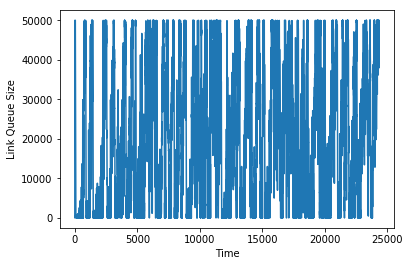

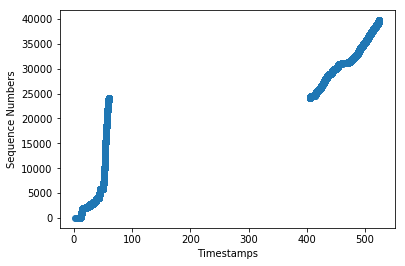

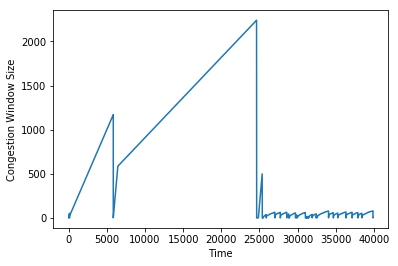

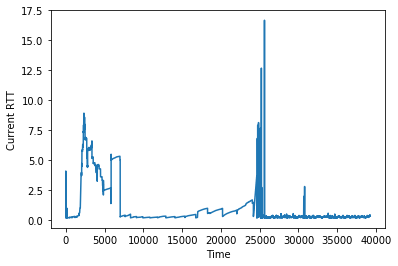

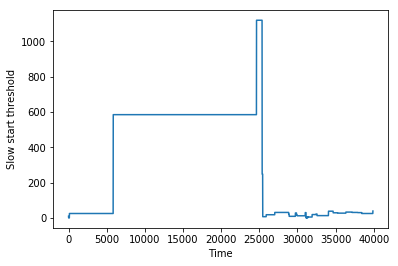


Results for sender 39115:
Total Acks: 20174
Num Duplicate Acks: 1004
% duplicate acks: 4.976703
Throughput (bytes/s): 12780.000000
Average RTT (ms): 273.385125


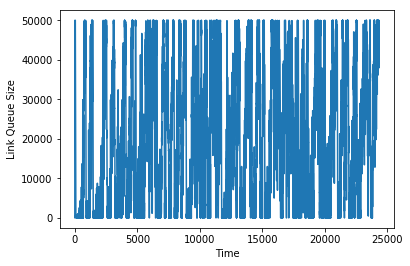

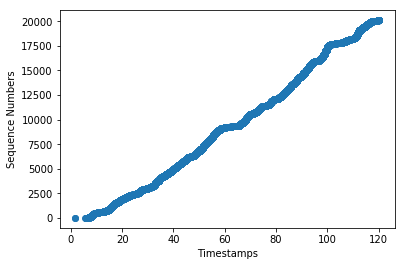

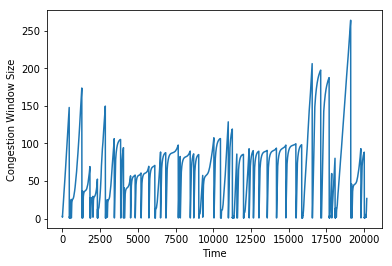

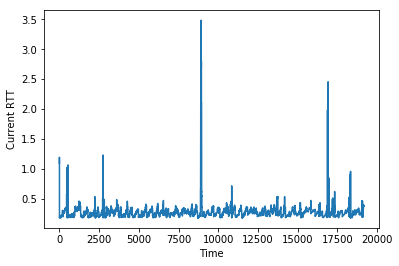

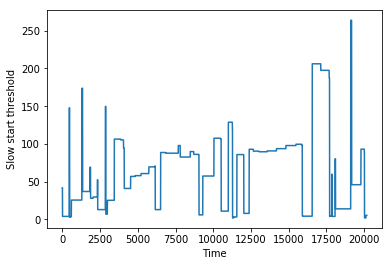

In [18]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS']
}


port1 = get_open_udp_port()
port2 = get_open_udp_port()

strat1 = TahoeStrategy(10, 1)
strat2 = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat), Sender(port2, strat2)])

[sender] Connected to receiver: 100.64.0.4:40144

[sender] Connected to receiver: 100.64.0.4:40144

Timedout packet id: 0 and current seq_num is 1
Timedout packet id: 1 and current seq_num is 3
Timedout packet id: 31 and current seq_num is 47
Timedout packet id: 47 and current seq_num is 57
Results for sender 50636:
Total Acks: 47
Num Duplicate Acks: 0
% duplicate acks: 0.000000
Throughput (bytes/s): 31.333333
Average RTT (ms): 5914.869065


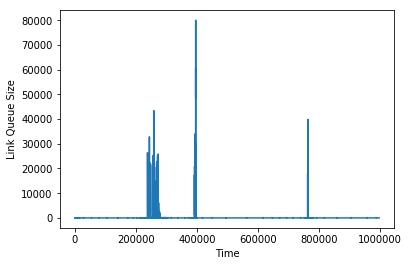

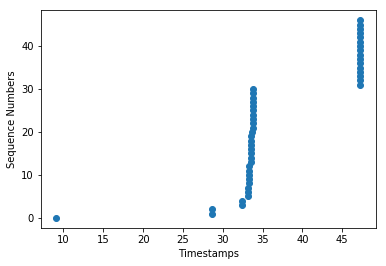

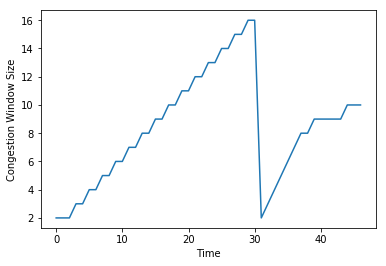

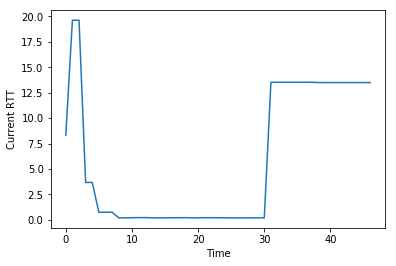

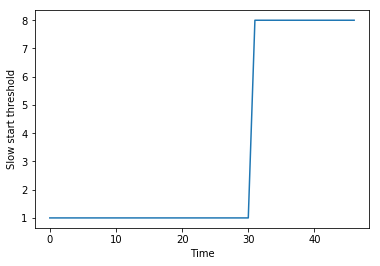


Results for sender 46300:
Total Acks: 5987
Num Duplicate Acks: 0
% duplicate acks: 0.000000
Throughput (bytes/s): 3991.333333
Average RTT (ms): 13938.342995


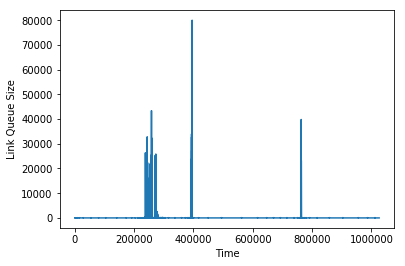

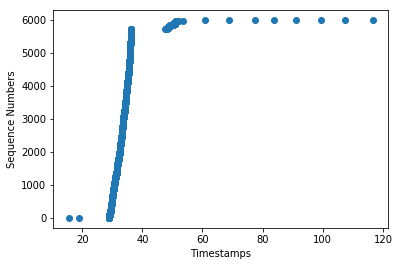

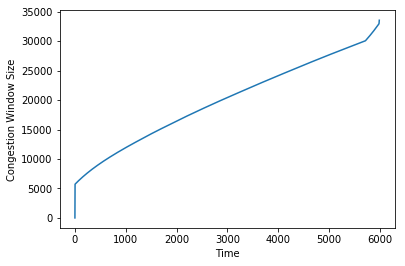

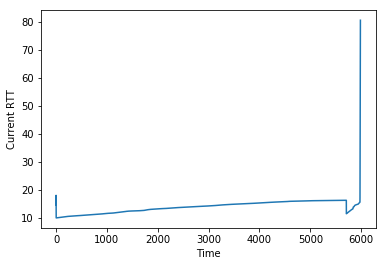

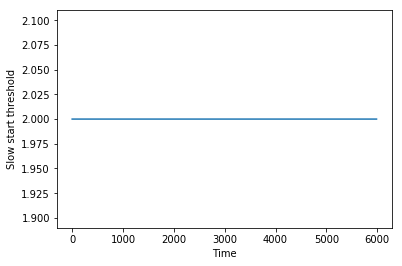

In [19]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 80000,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port1 = get_open_udp_port()
port2 = get_open_udp_port()

strat1 = TahoeStrategy(10, 1)
strat2 = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

In [ ]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}


In [ ]:
mahimahi_settings = {
    'delay': 45,
    'queue_size': 450,
    'trace_file': TRACE_FILES['114.68MBPS']
}


In [ ]:
# Absurd Queue Size case

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}
